> Created on Created on Sat Jul  4 10:29:03 2020 @author: Richie Bao-caDesign设计(cadesign.cn) 

## 1. 正态分布与概率密度函数，异常值处理
在上一节中，定义了`frequency_bins(df,bins)`频数分布计算函数，并以直方图（柱状图）的形式打印图表查看数据变化，但是其中在组距确定时是根据经验调整组距来观察数据的分布情况，并计算所有区间价格频数所占的百分比。那么是否有一种方法判断该组数据为正态分布？如果是，是否能够根据正态分布的概率准确计算出某一价格，或者一个价格区间出现的比例？ 

首先调入数据计算组距为5时的频数。将频数分布计算函数放置于公用的`util_poi`文件中，方便调用。

In [54]:
import util_poi
import pandas as pd
poi_gpd=pd.read_pickle('./data/poiAll_gpd.pkl') #读取已经存储为.pkl格式的POI数据，其中包括geometry字段，为GeoDataFrame地理信息数据，可以通过poi_gpd.plot()迅速查看数据。
delicacy_price=poi_gpd.xs('poi_0_delicacy',level=0).detail_info_price  #提取美食价格数据
delicacy_price_df=delicacy_price.to_frame(name='price').astype(float)
bins=list(range(0,300+5,5))+[600] #配置分割区间（组距），因为直方图更容易解读差异小的数值，而美食的价格分布标准差较大，即离散程度较大，因此在组距划分时，远离中心值的部分并非为等距划分。
poiPrice_fre=util_poi.frequency_bins(delicacy_price_df,bins) 
print(poiPrice_fre.head())

      index  fre    relFre  median  fre_percent%
0    [0, 5)    1  0.000435     0.0      0.043459
1   [5, 10)   35  0.015211     8.0      1.521078
2  [10, 15)  159  0.069100    12.0      6.910039
3  [15, 20)  264  0.114733    17.0     11.473272
4  [20, 25)  202  0.087788    22.0      8.778792


### 1.1 正态分布与概率密度函数
#### 1.1.1正态分布
在继续概率密度函数之前，认识下正态分布，又称常态分布、高斯分布（normal distribution/Gaussian distribution），因为正态分布的形状，正态分布常见的名称为钟形曲线（bell curve）。用numpy库中的`numpy.random.normal()`方法生成满足指定平均值、和标准差的一维数据（也可以用scipy库stats类中提供的norm的方法），并打印直方图和对应的由概率密度函数计算的分布曲线。下图y轴表示随机生成数值的频数(因为配置了density=Ture，返回的频数为标准化后的结果)，x轴为随机生成的数据集数值分布，因为设置了plt.hist()中`bins=30`，即将数值分为30等分，计算每一等分（频数宽度）的频数。曲线的顶点为均值、中位数和众数，频数为最高，对应的值为0，该值也为众数。可以从新定义平均数mu参数的值，曲线顶点也会随之变动。从众数向两侧移动，曲线高度下降，表示这些值出现的情形逐渐减少，即频数降低。在统计学上下图可以文字描述为：x服从平均值为0，标准差为0.1的正态分布。

依据正态分布的形状，其三个基本性质为：一是，它是对称的，意味左右部分互为镜像；二是，均值、中位数和众数处于同一位置，且在分布的中心，即钟形的顶点。表现为曲线中心最高，首尾两端向下倾斜，呈单峰状；三是，正态分布是渐近的，意味分布的左尾和右尾永远不会触及底线，即x轴。

正态分布具有重要意义，自然界与人类社会中经常出现正态分布的各类数据，例如经济中的收入水平，人的智商（IQ）分数和考试成绩，自然界中受大量微小随机扰动影响的事物等，因此能够依据这一现象推断出现某种情形的准确概率。同时，需要注意，正态分布是统计学中所谓的理论分布，即很少有数值严格服从正态分布，而是近似于，也有可能相差较远。违背正态分布假设，则依据正态分布假设所计算的概率结果将不再有效。

> 对于统计学的知识，通常均是依据已出版的著作或者教材为依据进行解说，并根据待阐述的内容，以python语言为工具分析数据的变化，从而可以直接应用代码来解决对应的问题，并能够通过具体的数据分析更深入的理解统计学相关的知识。本节参考：Timothy C.Urdan.Statistics in Plain English(白话统计学)[M].中国人民大学出版社.2013,12.第3版.

mean<0.01: True
sigmag variance<0.01 True


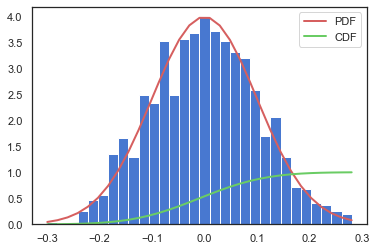

In [55]:
#下述案例参考SciPy.org 中`numpy.random.normal`案例
import numpy as np
import math
#依据分布配置参数生成数据 Draw samples from the distribution
mu, sigma = 0, 0.1 #配置平均值和标准差 mean and standard deviation
s=np.random.normal(mu, sigma, 1000)
#验证生成的数据是否满足配置参数 Verify the mean and the variance
print("mean<0.01:",abs(mu - np.mean(s)) < 0.01)
print("sigmag variance<0.01",abs(sigma - np.std(s, ddof=1)) < 0.01)
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, bins=30,density=True) #参数density=True,   If True, the first element of the return tuple will be the counts normalized to form a probability density
PDF=1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ) #y方向的值计算公式即为概率密度函数
plt.plot(bins,PDF ,linewidth=2, color='r',label='PDF') 

CDF=PDF.cumsum() #计算累计分布函数
CDF/=CDF[-1] #通过除以最大值，将CDF数值分布调整在[0,1]的区间
plt.plot(bins,CDF,linewidth=2, color='g',label='CDF') 

plt.legend()
plt.show()

#### 1.1.2 概率密度函数（Probability density function，PDF）
当直方图的组距无限缩小至极限后，能够拟合出一条曲线，计算这个分布曲线的公式即为概率密度函数：$f(x)= \frac{1}{ \sigma  \times  \sqrt{2 \pi } }  \times  e^{- \frac{1}{2}  [ \frac{x- \mu }{  \sigma  } ]^{2} } $ 其中，$\sigma$为标准差；$\mu$为平均值;$e$为自然对数的底，其值大约为2.7182...。在上述程序中，计算概率论密度函数时，并未计算每个数值，而是使用Plt.hist()返回值bins替代，即每一组距的左边沿和右边沿，这里是划分了30份，因此首位数为第1个频数宽度的左边沿，末位数为最后一个频数宽度的右边沿，而中间的所有是左右边沿重叠。而概率密度函数的积分，即为累计分布函数（cumulative distribution function ,CDF），可以用`numpy.cumsum()`计算 ，为给定轴上数组元素的累积和。

图表打印的库主要包括[Matplotlib](https://matplotlib.org/)，[plotly(含dash)](https://plotly.com/)，[bokeh](https://docs.bokeh.org/en/latest/index.html)，[seaborn](https://seaborn.pydata.org/)等，具体选择哪个打印图表，没有固定的标准，通常根据当前数据图表打印的目的、哪个库能够满足要求，以及个人更习惯用哪个库来确定。在上述使用Matplotlib库打印密度函数曲线时，是自行计算，而Seaborn提供了`seaborn.distplot()`方法，指定bins参数后可以直接获取上述结果。需要注意bins参数的配置，如果为一个整数值，则是划分同宽度频数宽度（bin）的数量，如果是列表，则为频数宽度的边缘，例如[1,2,3,4]，表示[[1,2),[2,3),[3,4]]的频数宽度列表，`[`代表包含左边沿数据，`]`代表包含右边沿数据,而`(`，和`)`则是分别代表不包含左或右边沿数据。同pandas的`pandas.core.indexes.range.RangeIndex`即RangeIndex数据格式。

返回到实验数据，直接计算打印POI美食数据的价格概率密度函数的值（纵轴），并连为曲线（分布曲线）。为了进一步观察，组距不断缩小时，与曲线的拟合程度，定义一个循环打印多个连续组距变化下的直方图，来观察直方图的变化情况。

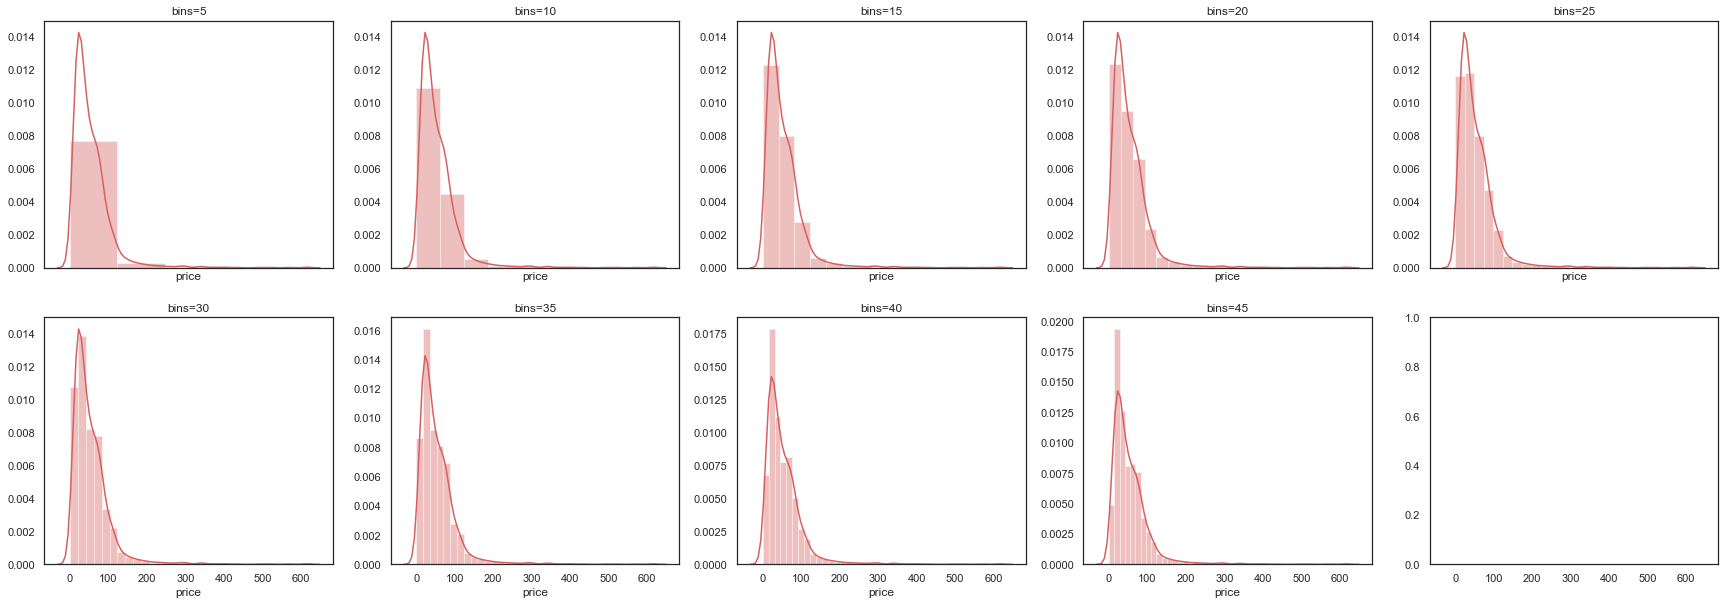

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
sns.set(style="white", palette="muted", color_codes=True)
bins=list(range(0,50,5))[1:]
bin_num=len(bins)

ncol=5
nrow=math.ceil(bin_num/ncol)
fig, axs = plt.subplots(ncols=ncol,nrows=nrow,figsize=(30,10),sharex=True)
ax=[(row,col) for row in range(nrow) for col in range(ncol)]
i=0
for bin in bins:
    sns.distplot(delicacy_price_df.price, bins=bin, color="r",ax=axs[ax[i]],kde = True,norm_hist=True).set(title="bins=%d"%bin)
    i+=1

#### 1.1.3 偏度与峰度
描述正态分布的特征（或概率密度函数的分布曲线）有两个概念，一个是偏度（skew）,另一个是峰度（kurtosis）。

由scipy库skewnorm方法建立具有正偏态、和负偏态属性的数据，并由skew方法计算偏度值，其公式为：$skewness= \frac{3( \ \mu  -median)}{ \sigma } $ 其中$\mu$为均值；$sigma$为标准差。偏度值为负，即负偏态，则概率密度函数左侧尾部比右侧长；偏度值为正，即正偏态，概率密度函数右侧尾部比左侧长。

由numpy建立具有尖峰分布（瘦尾）、和扁峰分布（厚尾）属性的数据，配置其绝对值参数均为0，变化标准差，并使用scipy库kurtosis方法计算其峰度值(峰度值计算有多个公式，不同软件平台公式也会有所差异)。其中当平均值为0，标准差为1时的正态分布为标准正态分布，概率密度函数公式可以简化为：$f(x)= \frac{1}{   \sqrt{2 \pi } }  \times  e^{- \frac{ x^{2}}{2}}$

> 注意，在用numpy生成数据集时，间接使用了方差$ \sigma ^{2} $的参数，其概率密度函数公式可以调整为：$f(x |  \mu ,  \sigma ^{2} )= \frac{1}{ \sqrt{2 \pi } \sigma ^{2} }  \times  e^{- \frac{ (x- \mu )^{2} }{2\sigma ^{2} }  } $, $\sigma ^{2}$即方差：  $\sigma ^{2} =   \frac{1}{N}   \sum_{i=1}^N { ( x_{i}- \mu ) ^{2} } $

skewness for data: [0.9125176711044238, -0.9104789042162033]
kurtosis for data: [0.02154265521668819, 0.16883950187654806, 0.12793925195885514]


[]

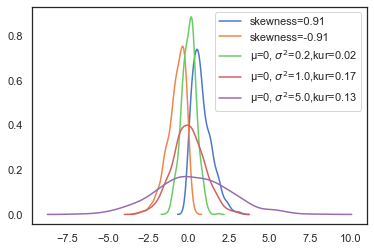

In [57]:
#建立具有正偏态、和负偏态属性的数据
from scipy.stats import skewnorm
from scipy.stats import skew
import matplotlib.pyplot as plt
skew_list=[7,-7]
skewNorm_list=[skewnorm.rvs(a, scale=1,size=1000,random_state=None) for a in skew_list]
skewness=[skew(d) for d in skewNorm_list]
print('skewness for data:',skewness) #验证偏度值

#建立具有尖峰分布、和扁峰分布属性的数据
import numpy as np
import math
from scipy.stats import kurtosis
mu_list=[0,0,0,]
variance=[0.2,1.0,5.0,]
normalDistr_paras=zip(mu_list,[math.sqrt(sig2) for sig2 in variance])#配置多个平均值和标准差对
s_list=[np.random.normal(para[0], para[1], 1000) for para in normalDistr_paras]
kur=[kurtosis(s,fisher=True) for s in s_list]
print("kurtosis for data:",kur)

i=0
for skew_data in skewNorm_list:
    sns.kdeplot(skew_data,label="skewness=%.2f"%skewness[i])
    i+=1

n=0
for s in s_list:
    sns.kdeplot(s,label="μ=%s, $σ^2$=%s,kur=%.2f"%(mu_list[n],variance[n],kur[n]))
    n+=1  
plt.plot()

返回实验数据，计算POI美食数据价格的偏度和峰度。偏度计算结果值为正，为正偏态，概率密度函数右侧尾部比左侧长，说明多数价格较低，少数较高价格将分布的尾巴托向另一端。峰度为尖峰分布。

In [58]:
delicacy_price_df_clean=delicacy_price_df.dropna()
print("skewness:%.2f, kurtosis:%.2f"%(skew(delicacy_price_df_clean.price),kurtosis(delicacy_price_df_clean.price,fisher=True)))

skewness:3.61, kurtosis:22.34


#### 1.1.4 检验数据集是否服从正态分布
首先计算标准计分，标准化价格数据集后其平均值为0，标准差为1，绘制概率密度函数分布曲线（理论值），同时叠加满足上述条件由numpy随机生成，满足正态分布数据集的分布曲线（观察值），可以比较二者的差异。因为实验数据即美食价格是正偏态，可以观察到位于均值左侧的数据有所差异，而右侧趋势基本吻合。同时，具有较高的峰度值，高于标准正态分布曲线。因为之后还会调用该部分代码来比较数据集与标准正态分布，因此将其定义为函数。

mean:53.70, SD:48.48
norm_mean:0.00, norm_SD:1.00


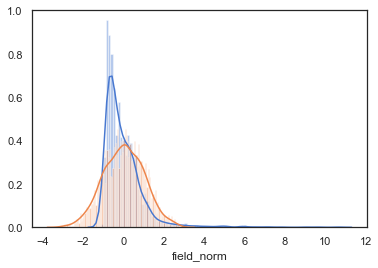

In [59]:
import pandas as pd
pd.options.mode.chained_assignment=None
def comparisonOFdistribution(df,field,bins=100):
    import pandas as pd
    import numpy as np
    import seaborn as sns
    '''
    funciton-数据集z-score概率密度函数分布曲线(即观察值/实验值 observed/empirical data)与标准正态分布(即理论值 theoretical set)比较
    
    Params:
    df - 包含待分析数据集的DataFrame格式类型数据
    field - 指定所分析df数据的列名
    bins - 指定频数宽度，为单一整数代表频数宽度（bin）的数量，或者列表，代表多个频数宽度的列表
    '''
    df_field_mean=df[field].mean()
    df_field_std=df[field].std()
    print("mean:%.2f, SD:%.2f"%(df_field_mean,df_field_std))

    df['field_norm']=df[field].apply(lambda row: (row-df_field_mean)/df_field_std) #标准化价格(标准计分，z-score)，即标准计分，或者使用上一章节用到的方法`from scipy.stats import zscore`

    #验证z-score，标准化后的均值必为0， 标准差必为1.0
    df_fieldNorm_mean=df['field_norm'].mean()
    df_fieldNorm_std=df['field_norm'].std()
    print("norm_mean:%.2f, norm_SD:%.2f"%(df_fieldNorm_mean,df_fieldNorm_std))
  
    sns.distplot(df['field_norm'], bins=bins,)

    s=np.random.normal(0, 1, len(df[field]))
    sns.distplot(s, bins=bins)
comparisonOFdistribution(delicacy_price_df_clean,'price',bins=100)    

* 异常值处理

偏度的差异从直方图或者箱型图中可以观察到有少数部分较高的价格出现，假设该部分价格为异常值，那么去除异常值后，数据集的分布曲线又会有什么样的变化？

处理异常值，先建立简单数据来理解异常值，并找到相应的方法。首先参考：Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and Handle Outliers", The ASQC Basic References in Quality Control: Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 使用其中提供的方法，其公式为：

$MAD= median_{i}{ \{ |  x_{i}-   \widetilde{x} |\} }$ ，其中MAD（the median of the absolute deviation about the median /Median Absolute Deviation）为绝对中位差，其中$\widetilde{x}$为中位数；

$M_{i}= \frac{0.6745( x_{i} - \widetilde{x} )}{MAD}$  ，其中$M_{i}$为修正的z-score(modified  z-score)，$\widetilde{x}$为中位数。

根据之下计算结果，该公式能够有效的判断异常值。

[False False False False False False False False  True  True] [2.1 2.6 2.4 2.5 2.3 2.1 2.3 2.6]
原始数据描述: count    785.000000
mean      53.584076
std       44.123529
min        5.000000
25%       23.000000
50%       43.000000
75%       72.000000
max      571.000000
Name: price, dtype: float64
--------------------------------------------------
异常值处理后数据描述: count    770.000000
mean      49.766883
std       31.433613
min        5.000000
25%       23.000000
50%       42.000000
75%       71.000000
max      159.000000
Name: price, dtype: float64


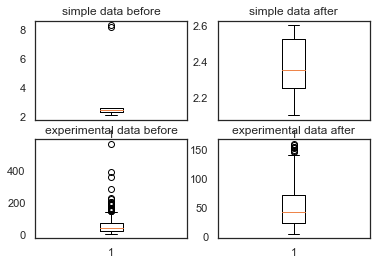

In [11]:
import numpy as np
import matplotlib.pyplot as plt
outlier_data=np.array([2.1,2.6,2.4,2.5,2.3,2.1,2.3,2.6,8.2,8.3]) #建立简单的数据，便于观察
ax1=plt.subplot(221)
ax1.margins(0.05) 
ax1.boxplot(outlier_data)
ax1.set_title('simple data before')

def is_outlier(data,threshold=3.5):
    import numpy as np
    '''
    function-判断异常值
        
    Params:
    data - 待分析的数据，列表或者一维数组
    threshold - 判断是否为异常值的边界条件    
    '''
    MAD=np.median(abs(data-np.median(data)))
    modified_ZScore=0.6745*(data-np.median(data))/MAD
    #print(modified_ZScore)
    is_outlier_bool=modified_ZScore>threshold    
    return is_outlier_bool,data[~is_outlier_bool]
    
is_outlier_bool,data_clean=is_outlier(outlier_data,threshold=3.5)    
print(is_outlier_bool,data_clean)

ax2=plt.subplot(222)
ax2.margins(0.05) 
ax2.boxplot(data_clean)
ax2.set_title('simple data after')

_,delicacyPrice_outliersDrop=is_outlier(delicacy_price_df_clean.price,threshold=3.5)
print("原始数据描述:",delicacy_price_df_clean.price.describe())
print("-"*50)
print("异常值处理后数据描述:",delicacyPrice_outliersDrop.describe())

ax3=plt.subplot(223)
ax3.margins(0.05) 
ax3.boxplot(delicacy_price_df_clean.price)
ax3.set_title('experimental data before')

ax3=plt.subplot(224)
ax3.margins(0.05) 
ax3.boxplot(delicacyPrice_outliersDrop)
ax3.set_title('experimental data after')

plt.show()

mean:49.77, SD:31.43
norm_mean:0.00, norm_SD:1.00


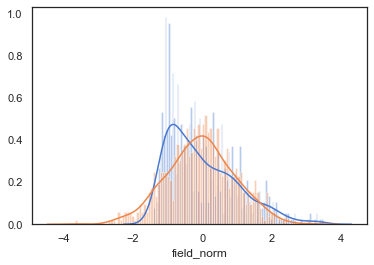

In [12]:
comparisonOFdistribution(pd.DataFrame(delicacyPrice_outliersDrop,columns=['price']),'price',bins=100)

如果将较高的价格视为异常值移除，调用定义的`comparisonOFdistribution(df,field,bins=100)`函数打印移除后值的概率密度函数，比较标准正态分布可以发现右侧，即较高的值部分发生了变化,其它的部分未发生明显变化。那么如何检验数据集是否服从正态分布？scipy库提供有多种正态性检验的方法，分别为`kstest`，`shapiro`，`normaltest`，`anderson`。计算结果显示的p-value基本为0，即p-value<0.05,拒绝原假设，清理异常值后的美食价格数据集仍不服从正态分布，即为非正态数据集。只有正态分布可以计算从一个总体中选取特定值或区间的概率，本次美食价格数据集为正偏和尖峰分布，为非正态数据集，正态分布的概率不能很好适用于该类数据集。

In [13]:
from scipy import stats
kstest_test=stats.kstest(delicacyPrice_outliersDrop,cdf='norm')
print(kstest_test)

shapiro_test=stats.shapiro(delicacyPrice_outliersDrop) #官方文档注释，当N>5000时，只有统计量正确，但是p-value值不一定正确.本次实验`len(delicacyPrice_outliersDrop)`数据量为770，可以使用
print("shapiroResults(statistic=%f,pvalue=%f)"%(shapiro_test))

normaltest_test=stats.normaltest(delicacyPrice_outliersDrop,axis=None)
print(normaltest_test)

anderson_test=stats.anderson(delicacyPrice_outliersDrop,dist='norm')
print(anderson_test)

KstestResult(statistic=0.9999997133484281, pvalue=0.0)
shapiroResults(statistic=0.922036,pvalue=0.000000)
NormaltestResult(statistic=81.9249012085564, pvalue=1.6226831906209503e-18)
AndersonResult(statistic=16.928516711550174, critical_values=array([0.573, 0.653, 0.783, 0.913, 1.086]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


#### 1.1.5 给定特定值计算概率，以及找到给定概率的值
如果数据集服从正态分布，则可以直接使用scipy库stats类中提供的norm的方法进行计算。下述案例参考scipy官网。使用norm.cdf(),norm.sf()和norm.ppf()分别计算小于或等于特定值、大于或等于特定值、或找到给定概率的值进行计算。

mean, var, skew, kurt= (array(0.), array(1.), array(0.), array(0.))
验证累计分布函数CDF返回值与其PPF返回值是否相等或近似： True


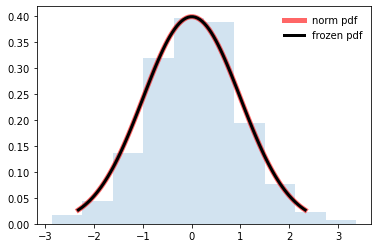

In [5]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = norm.stats(moments='mvsk')  
print('mean, var, skew, kurt=',(mean, var, skew, kurt)) #验证符合标准正态分布的相关统计量
x=np.linspace(norm.ppf(0.01),norm.ppf(0.99), 100) #norm.ppf 百分比点函数 - Percent point function (inverse of cdf — percentiles)
ax.plot(x, norm.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')  #norm.pdf为概率密度函数
rv=norm() #固定形状（偏度和峰度）、位置loc（平均值）和比例scale（标准差）参数，即指定固定值
ax.plot(x, rv.pdf(x), 'k-', lw=3, label='frozen pdf') #固定/“冻结”分布（frozen distribution）

vals = norm.ppf([0.001, 0.5, 0.999]) #返回概率为0.1%、50%和99.9%的值，默认loc=0,scale=1
print("验证累计分布函数CDF返回值与其PPF返回值是否相等或近似：",np.allclose([0.001, 0.5, 0.999], norm.cdf(vals)))

r=norm.rvs(size=1000) #指定数据集大小
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

In [3]:
#如果需要计算概率则定义固定分布的数据集。
import seaborn as sns
print("用.cdf计算值小于或等于113的概率为：",norm.cdf(113,100,12)) #pdf(x, loc=0, scale=1) 配置Loc(均值)和scale(标准差)
print("用.sf计算值大于或等于113待概率为：",norm.sf(113,100,12)) 
print("可以观察到.cdf（<=113）概率结果+.sf(>=113)概率结果为：",norm.cdf(113,100,12)+norm.sf(113,100,12))
print("用.ppf找到给定概率值为98%的数值为：",norm.ppf(.98,100,12))

用.cdf计算值小于或等于113的概率为： 0.8606697525503779
用.sf计算值大于或等于113待概率为： 0.13933024744962208
可以观察到.cdf（<=113）概率结果+.sf(>=113)概率结果为： 1.0
用.ppf找到给定概率值为98%的数值为： 124.64498692758187


在传统的概率计算中，已知z-score，即标准计分，可以通过查表的方式来获取对应的概率值，这种方式已经很少使用。为了直观的观察概率值，由曲线、横轴和通过对应概率密度函数值的垂直线围合的面积即为概率值，通过绘制图表可以更清晰的观察。

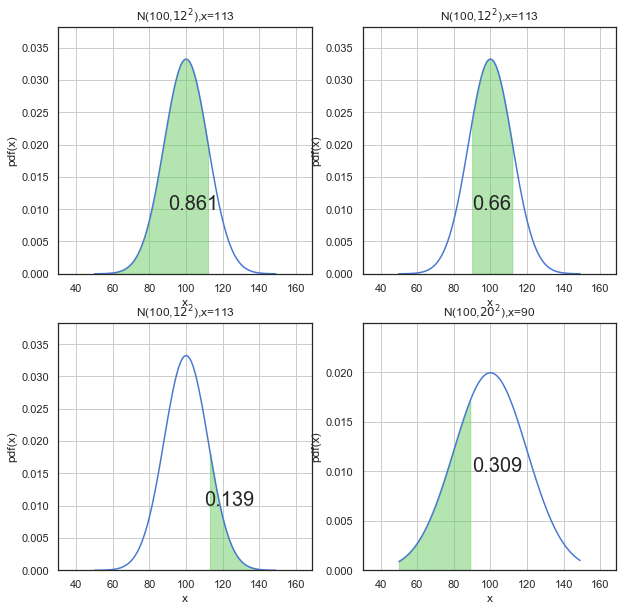

In [132]:
def probability_graph(x_i,x_min,x_max,x_s=-9999,left=True,step=0.001,subplot_num=221,loc=0,scale=1):
    import math
    '''
    function - 正态分布概率计算及图形表述
    
    Paras:
    x_i - 待预测概率的值
    x_min - 数据集区间最小值
    x_max - 数据集区间最大值
    x_s - 第2个带预测概率的值，其值大于x_i值
    left - 是否计算小于或等于，或者大于或等于指定值的概率
    step - 数据集区间的步幅
    subplot_num - 打印子图的序号，例如221中，第一个2代表列，第二个2代表行，第三个是子图的序号，即总共2行2列总共4个子图，1为第一个子图
    loc - 即均值
    scale - 标准差
    '''
    x=np.arange(x_min,x_max,step)
    ax=plt.subplot(subplot_num)
    ax.margins(0.2) 
    ax.plot(x,norm.pdf(x,loc=loc,scale=scale))
    ax.set_title('N(%s,$%s^2$),x=%s'%(loc,scale,x_i))
    ax.set_xlabel('x')
    ax.set_ylabel('pdf(x)')
    ax.grid(True)
    
    if x_s==-9999:
        if left:
            px=np.arange(x_min,x_i,step)
            ax.text(loc-loc/10,0.01,round(norm.cdf(x_i,loc=loc,scale=scale),3), fontsize=20)
        else:
            px=np.arange(x_i,x_max,step)
            ax.text(loc+loc/10,0.01,round(1-norm.cdf(x_i,loc=loc,scale=scale),3), fontsize=20)
        
    else:
        px=np.arange(x_s,x_i,step)
        ax.text(loc-loc/10,0.01,round(norm.cdf(x_i,loc=loc,scale=scale)-norm.cdf(x_s,loc=loc,scale=scale),2), fontsize=20)
    ax.set_ylim(0,norm.pdf(loc,loc=loc,scale=scale)+0.005)
    ax.fill_between(px,norm.pdf(px,loc=loc,scale=scale),alpha=0.5, color='g')
plt.figure(figsize=(10,10))
probability_graph(x_i=113,x_min=50,x_max=150,step=1,subplot_num=221,loc=100,scale=12)
probability_graph(x_i=113,x_min=50,x_max=150,step=1,left=False,subplot_num=223,loc=100,scale=12)
probability_graph(x_i=113,x_min=50,x_max=150,x_s=90,step=1,subplot_num=222,loc=100,scale=12)
probability_graph(x_i=90,x_min=50,x_max=150,step=1,subplot_num=224,loc=100,scale=20)
plt.show()

### 1.2 要点
#### 1.2.1 数据处理技术
* 正态分布与概率密度函数等统计分析工具<scipy与numpy库>

-生成服从正态分布的数据集，`s=np.random.normal(0, 1, len(df[field]))`

-指定偏度值生成偏态分布随机变量(A skew-normal random variable),`skewNorm_list=[skewnorm.rvs(a, scale=1,size=1000,random_state=None) for a in skew_list]`

-计算峰度值,`kur=[kurtosis(s,fisher=True) for s in s_list]`

-计算偏度值，`print("skewness:%.2f, kurtosis:%.2f"%(skew(delicacy_price_df_clean.price),kurtosis(delicacy_price_df_clean.price,fisher=True)))` 也含峰度值计算

-验证是否是正态分布,

`kstest_test=stats.kstest(delicacyPrice_outliersDrop,cdf='norm')`
`shapiro_test=stats.shapiro(delicacyPrice_outliersDrop)`
`normaltest_test=stats.normaltest(delicacyPrice_outliersDrop,axis=None)`
`anderson_test=stats.anderson(delicacyPrice_outliersDrop,dist='norm')`

-计算正态分布数据集的概率，或者指定概率返回值，

`print("用.cdf计算值小于或等于113的概率为：",norm.cdf(113,100,12)) #pdf(x, loc=0, scale=1) 配置Loc(均值)和scale(标准差)`
`print("用.sf计算值大于或等于113待概率为：",norm.sf(113,100,12)) `
`print("可以观察到.cdf（<=113）概率结果+.sf(>=113)概率结果为：",norm.cdf(113,100,12)+norm.sf(113,100,12))`
`print("用.ppf找到给定概率值为98%的数值为：",norm.ppf(.98,100,12))`

* 概率密度函数图表

-用matlotlib库，

`plt.plot(bins,PDF ,linewidth=2, color='r',label='PDF')`  
`plt.plot(bins,CDF,linewidth=2, color='g',label='CDF')` 累计分布函数

-用seaborn库，

`sns.distplot(delicacy_price_df.price, bins=bin, color="r",ax=axs[ax[i]],kde = True,norm_hist=True).set(title="bins=%d"%bin)`
`sns.kdeplot(skew_data,label="skewness=%.2f"%skewness[i])`

* 其它工具

-延给定轴的数值累计和（numpy），CDF=PDF.cumsum()

-向上取值，nrow=math.ceil(bin_num/ncol)

#### 1.5.2 新建立的函数工具

* funciton-数据集z-score概率密度函数分布曲线(即观察值/实验值 observed/empirical data)与标准正态分布(即理论值 theoretical set)比较，comparisonOFdistribution(df,field,bins=100)
* function-判断异常值，is_outlier(data,threshold=3.5)

#### 1.5.3 所调用的python库

In [ ]:
import util_poi #自定义工具集
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skewnorm
from scipy.stats import skew
from scipy.stats import kurtosis